#### Inputs

In [48]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

from extraction.extract import generateNNdataMultiple
from extraction.extractionvalues import *
from extraction.extractadjacency import getAdjacencyMatrix, distance_weight_adjacency


%load_ext tensorboard
# %tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


##### Data parameters

In [49]:
airports = ICAOTOP10
n_nodes = n_airports = len(airports)
start = datetime(2019, 3, 1)
end = datetime(2019, 3, 31)
timeslotLength = 60

##### Load Data

In [50]:
dataDict = generateNNdataMultiple(
            airports,
            timeslotLength,
            GNNFormat=True,
            start=start,
            end=end,
        )

times = (list(dataDict.values())[0]["T"])

weight = 0.7

Aarray = getAdjacencyMatrix(airports, start, end)* weight + (1-weight) * distance_weight_adjacency(airports, 400)
print(Aarray.shape) ## MISSING ONE GRAPH HERE

100%|██████████| 10/10 [00:00<00:00, 34.84it/s]


(720, 10, 10)


##### Process Data

In [51]:
columnsToDrop = ["weekend", "winter", "spring", "summer", "autumn", "night", "morning", "afternoon"]
# print(dataDict["EGLL"]["X"].shape)
Xlist = []
Ylist = []
for airport in airports:
    # T x F
    X = dataDict[airport]["X"].drop(columnsToDrop, axis=1).to_numpy()
    Xlist.append(X)
    
    Y = dataDict[airport]["Y"].to_numpy()
    Ylist.append(Y)


Xlist = np.array(Xlist)
Ylist = np.array(Ylist)

# N x T x F
Xarray = np.swapaxes(Xlist, 0, 1)
Yarray = np.swapaxes(Ylist, 0, 1)

# Reshape to a flat array that goes arrival then departure delay
Yarray = np.reshape(Yarray, newshape=[len(times), len(airports)*2], order="F")

# print(Yarray.shape)
# T x N x F

# Normalise over the features
Xmean, Xstd = X.mean(axis=0), X.std(axis=0)
X = (X - Xmean) / Xstd
print("X Mean Shape", Xmean.shape)
Ymean, Ystd = Y.mean(axis=0), Y.std(axis=0)
Y = (Y - Ymean) / Ystd
print("Y Mean Shape", Ymean.shape)

print("T x N x F: ", "Xarray =", Xarray.shape, "|", "Yarray =", Yarray.shape, "|", "Aarray =", Aarray.shape )

X Mean Shape (9,)
Y Mean Shape (2,)
T x N x F:  Xarray = (720, 10, 9) | Yarray = (720, 20) | Aarray = (720, 10, 10)


In [52]:
train_split, val_split = 0.6, 0.1

fullLength = len(times)
train_idx = int(train_split * fullLength)
val_idx = int((val_split + train_split) * fullLength)
print(train_idx, val_idx)

Xtrain, Xval, Xtest = Xarray[0:train_idx], Xarray[train_idx:val_idx], Xarray[val_idx::]
Ytrain, Yval, Ytest = Yarray[0:train_idx], Yarray[train_idx:val_idx], Yarray[val_idx::]

Atrain, Aval, Atest = Aarray[0:train_idx], Aarray[train_idx:val_idx], Aarray[val_idx::]


432 503


##### Create tensorflow dataset

In [53]:
batch_size = 1
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False


def create_tf_dataset(
    data_array: np.ndarray,
    adjacencies_array: np.ndarray,
    target_array,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=False,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = timeseries_dataset_from_array(
        data_array[:-forecast_horizon],
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )
    adjacencies = timeseries_dataset_from_array(
        adjacencies_array[:-forecast_horizon],
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )


    dataset = inputs

    target_offset = (
       input_sequence_length
       if multi_horizon
       else input_sequence_length + forecast_horizon - 1) 
    target_seq_length = forecast_horizon if multi_horizon else 1

    targets = timeseries_dataset_from_array(
        target_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,)
    

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset =  create_tf_dataset(
    Xtrain, Atrain, Ytrain,  input_sequence_length,
    forecast_horizon,
    batch_size=batch_size,
    shuffle=False,
    multi_horizon=multi_horizon,
)

val_dataset =  create_tf_dataset(
    Xval, Aval, Yval,  input_sequence_length,
    forecast_horizon,
    batch_size=batch_size,
    shuffle=False,
    multi_horizon=multi_horizon,
)
test_dataset =  create_tf_dataset(
    Xtest, Atest, Ytest,  input_sequence_length,
    forecast_horizon,
    batch_size=batch_size,
    shuffle=False,
    multi_horizon=multi_horizon,
)


# Adjacency Matrix

In [54]:
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int, ):
        self.edges = edges
        

# adjacency_matrix = distance_weight_adjacency(airports, threshold=100000) # getAdjacencyMatrix(airports)[10]
# print(adjacency_matrix.shape)
# edges_test = []
# print(edges_test)
# edges_train = np.empty(1)
# edges_val = []
# for matrix in Atest:
#     node_indices, neighbor_indices = np.where(matrix !=0)
#     edges_test.append((node_indices.tolist(), neighbor_indices.tolist()))
    # edges_test = tf.concat([edges_test, tf.tuple(node_indices.tolist(), neighbor_indices.tolist())], axis=0)
# for matrix in Atrain:
#     node_indices, neighbor_indices = np.where(matrix != 0)
#     edges_test.append((node_indices, neighbor_indices))
# for matrix in Aval:
#     node_indices, neighbor_indices = np.where(matrix != 0)
#     edges_test.append((node_indices, neighbor_indices))
    

# edges_test = tf.data.Dataset.from_tensor_slices(edges_test)
# edges_train = tf.convert_to_tensor(edges_train)
# edges_val = tf.convert_to_tensor(edges_val)
# print(edges_test.shape)
# print(type(edges_test))
# graph = GraphInfo(
#     edges=(node_indices.tolist(), neighbor_indices.tolist()),
#     num_nodes=adjacency_matrix.shape[0],
# )
# print(graph.edges[1])


In [55]:
# plt.imshow(adjacency_matrix)
# plt.xticks(range(len(airports)), airports, fontsize=12, rotation=-90)
# plt.yticks(range(len(airports)), airports, fontsize=12, rotation=0)
# plt.show()

## Graph Convolution Layer

In [59]:

class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor, adjacancy):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)
        node_indices, neighbor_indices = adjacancy#np.where(adjacancy !=0)
        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                node_indices,
                num_segments=10, ##### CHANGE TO LEN(airports)
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor, adjacancy):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor, adjacancy):
        node_indices, neighbor_indices = adjacancy #np.where(adjacancy !=0)
        neighbour_representations = tf.gather(features, neighbor_indices.to_list())
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, inputs):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        features, adjacancy = inputs
        print(adjacancy)
        nodes_representation = self.compute_nodes_representation(features, adjacancy)
        aggregated_messages = self.compute_aggregated_messages(features, adjacancy)
        return self.update(nodes_representation, aggregated_messages)


## LSTM including graph convolution layer

In [60]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm1 = layers.LSTM(lstm_units, return_sequences=True, activation="tanh")
        self.lstm2 = layers.LSTM(lstm_units, activation="tanh")
        # self.dense = layers.Dense(output_seq_len)
        self.dense = layers.Dense(2)
        self.denseThick = layers.Dense(64)
        self.denseThick2 = layers.Dense(32)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """
        features, adjacancy = inputs
        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        features = tf.transpose(features, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batcsh_ize, input_seq_len, out_feat)
        # print(f"The GCN output shape  = {gcn_out}")
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        print(f"The input shape for the LSTM is {gcn_out}")
        lstm1_hi = self.lstm1(gcn_out)  # lstm_out has shape: (batch_size * num_nodes, lstm_units)
        lstm2_hi = self.lstm2(lstm1_hi)  # lstm_out has shape: (batch_size * num_nodes, lstm_units)
        print(f"The LSTM output shape  = {lstm2_hi}")
        dense_1 = self.denseThick(lstm2_hi)
        dense_2 = self.denseThick2(dense_1)
        dense_output = self.dense(dense_2)
        print(f"The Dense has output shape {dense_output}")  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        # output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        output = tf.reshape(dense_output, (2*num_nodes, batch_size, 1))
        print(f"output shape = {output}")
        final = tf.transpose(output, [1, 2, 0])  
        print(f"final shape = {final}")
        return final
        # # returns Tensor of shape (batch_size, output_seq_len, num_nodes)


## Training the model

In [61]:
in_feat = 9
# batch_size = 64
epochs = 10
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False
out_feat = 10
lstm_units = 64
graph = 1
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, len(airports), in_feat))
a_in = layers.Input((input_sequence_length, len(airports), len(airports)))
outputs = st_gcn([inputs, a_in])

model = keras.models.Model([inputs, a_in], outputs)

learning_rate = 0.0005
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss=MeanAbsoluteError(reduction="auto", name="mean_absolute_error"),
    weighted_metrics=["acc"],
)

model.summary()

Tensor("Placeholder_1:0", shape=(None, 12, 10, 10), dtype=float32)


OperatorNotAllowedInGraphError: Exception encountered when calling layer "lstmgc_6" (type LSTMGC).

in user code:

    File "C:\Users\trist\AppData\Local\Temp/ipykernel_17268/1544189337.py", line 48, in call  *
        gcn_out = self.graph_conv(
    File "C:\Users\trist\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    OperatorNotAllowedInGraphError: Exception encountered when calling layer "graph_conv_6" (type GraphConv).
    
    in user code:
    
        File "C:\Users\trist\AppData\Local\Temp/ipykernel_17268/2606012393.py", line 85, in call  *
            aggregated_messages = self.compute_aggregated_messages(features, adjacancy)
        File "C:\Users\trist\AppData\Local\Temp/ipykernel_17268/2506681714.py", line 58, in compute_aggregated_messages  *
            node_indices, neighbor_indices = adjacancy #np.where(adjacancy !=0)
    
        OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.
    
    
    Call arguments received:
      • inputs=['tf.Tensor(shape=(None, 12, 10, 9), dtype=float32)', 'tf.Tensor(shape=(None, 12, 10, 10), dtype=float32)']


Call arguments received:
  • inputs=['tf.Tensor(shape=(None, 12, 10, 9), dtype=float32)', 'tf.Tensor(shape=(None, 12, 10, 10), dtype=float32)']

In [ ]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=100), tensorboard_callback],
)


Layer LSTMGC has arguments ['self', 'in_feat', 'out_feat', 'lstm_units', 'input_seq_len', 'output_seq_len', 'graph_info', 'graph_conv_params']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/10
The input shape for the LSTM is Tensor("model_2/lstmgc_3/Reshape:0", shape=(None, 12, 20), dtype=float32)
The LSTM output shape  = Tensor("model_2/lstmgc_3/lstm_7/PartitionedCall:0", shape=(None, 64), dtype=float32)
The Dense has output shape Tensor("model_2/lstmgc_3/dense_9/BiasAdd:0", shape=(None, 2), dtype=float32)
output shape = Tensor("model_2/lstmgc_3/Reshape_1:0", shape=(20, None, 1), dtype=float32)
final shape = Tensor("model_2/l

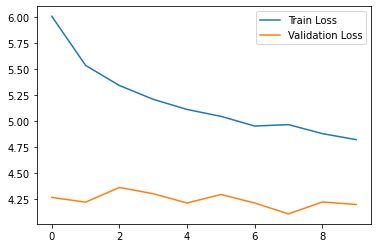

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

The input shape for the LSTM is Tensor("model_1/lstmgc_2/Reshape:0", shape=(None, 12, 20), dtype=float32)
The LSTM output shape  = Tensor("model_1/lstmgc_2/lstm_5/PartitionedCall:0", shape=(None, 64), dtype=float32)
The Dense has output shape Tensor("model_1/lstmgc_2/dense_6/BiasAdd:0", shape=(None, 2), dtype=float32)
output shape = Tensor("model_1/lstmgc_2/Reshape_1:0", shape=(20, None, 1), dtype=float32)
final shape = Tensor("model_1/lstmgc_2/transpose_1:0", shape=(None, 1, 20), dtype=float32)
203/203 [==============================] - 1s 3ms/step
(203, 20)
(203, 20)


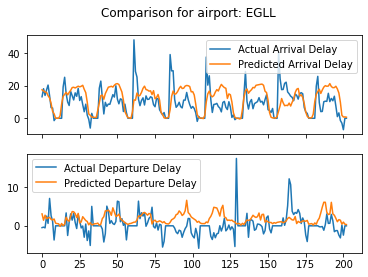

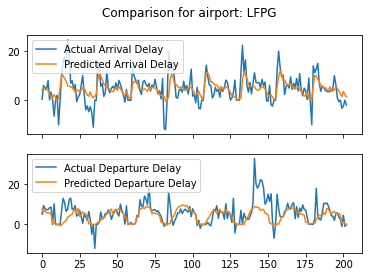

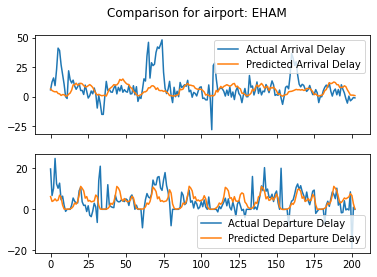

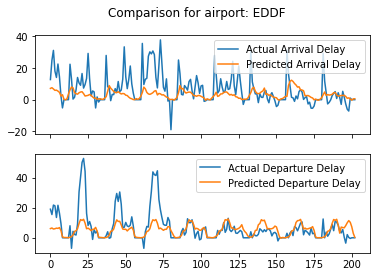

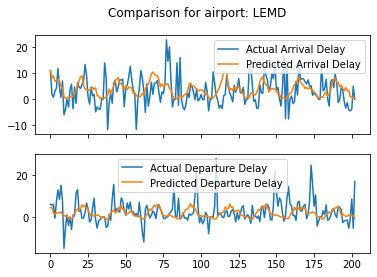

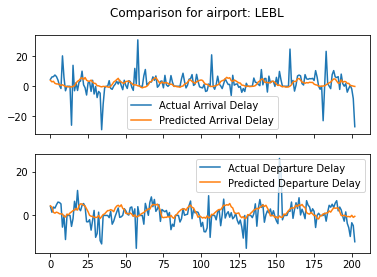

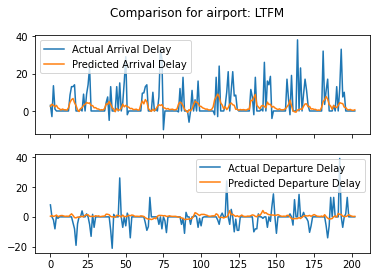

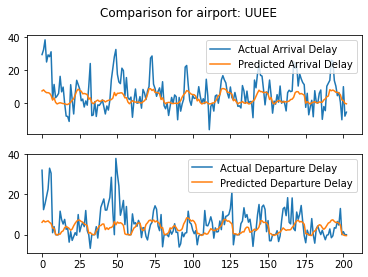

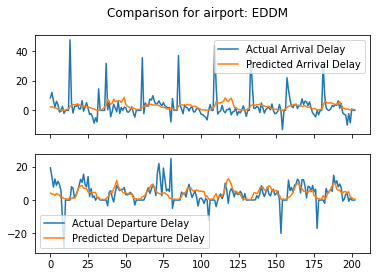

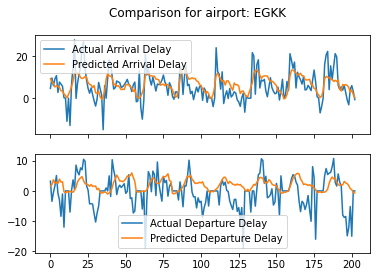

In [ ]:
ypredFull = model.predict(test_dataset, verbose=1)[:,0,:]
yactualFull = Ytest[14::,:]
print(ypredFull.shape)
print(yactualFull.shape)


def plotComparison(airport_index, ypredFull=ypredFull, yactualFull=yactualFull):
    fig, axs = plt.subplots(2, 1, sharex=True, num=airport_index)
    axs[0].plot(yactualFull[:, 0+airport_index], label="Actual Arrival Delay")
    axs[1].plot(yactualFull[:, 10+airport_index], label="Actual Departure Delay")
    axs[0].plot(ypredFull[:, 0+airport_index], label="Predicted Arrival Delay")
    axs[1].plot(ypredFull[:, 10+airport_index], label="Predicted Departure Delay")
    axs[0].legend()
    axs[1].legend()
    plt.suptitle(f"Comparison for airport: {airports[airport_index]}")

for airportidx in range(0,len(airports)):
    plotComparison(airportidx)
plt.show()


## Add logbook to tensorboard

In [ ]:
!tensorboard dev upload --logdir ./logs \
  --name "Test for tensorboard" \
  --description "test"\
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/C7CKFDtYTb2Xsl3NqVlM1w/

[2022-01-18T10:55:39] Started scanning logdir.
Data upload starting...
Uploading binary object (396.9 kB)...
Uploading binary object (400.1 kB)...
Uploading 120 scalars...
Uploading 260 tensors (186.6 kB)...
[2022-01-18T10:55:43] Total uploaded: 120 scalars, 260 tensors (186.6 kB), 2 binary objects (797.0 kB)
[2022-01-18T10:55:43] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/C7CKFDtYTb2Xsl3NqVlM1w/
